# Stuff to be added to Final Report

In [5]:
library(tidyverse)
library(ggcorrplot)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

Warning message:
"package 'ggcorrplot' was built under R version 4.1.3"


In [18]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"

bike_data <- 
#read.csv("data/SeoulBikeData.csv") |>
    read.csv(url, encoding = 'utf-8') |>
    setNames(c("date",
               "bike_count",
               "hour",
               "temperature",
               "humidity",
               "wind_speed",
               "visibility",
               "dew_point_temp",
               "radiation",
               "rain",
               "snow",
               "season",
               "holiday",
               "functional_day")) |>
    filter(functional_day == "Yes") |>
    select(-functional_day) 

#### 2.3.1 Multicollinearity

* In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.
* This suggests that the variables `dew_point_temp` and `temp` are indicating the presence of multicollinearity since they have a very high correlation of 0.91.
* To help us decide which of these 2 variables we should ommit from our analyses later on, we use the Variation Inflation Factor (VIF) method.

In [22]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour    temperature       humidity     wind_speed     visibility 
         1.180         87.644         20.163          1.274          1.575 
dew_point_temp      radiation           rain           snow 
       116.462          2.011          1.084          1.096

* James et al. (2013) in [*An Introduction to Statistical Learning*](https://www.statlearning.com/) indicate that, as a rule of thumb, a VIF value that exceeds 5 or 10 is an indicator of a  multicollinearity problem.
* We can clearly see that `dew_point_temp` has an extremely high VIF value of 116.46 therefore we decide to ommit it and see how the other VIFs are effected.

In [24]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday, dew_point_temp)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour temperature    humidity  wind_speed  visibility   radiation 
      1.178       1.629       2.533       1.272       1.564       1.911 
       rain        snow 
      1.071       1.091

* It is clear that `dew_point_temp` was creating multicollinearity thus we have decided to ommit it from any further analyses.

#### 2.3.2 Confounders and Causality

* We also suspect the categorical variable `season` to be a confounding factor in our data.
* This is because when choosing `bike_count` as our response variable $Y$ and `humidity` as our input variables $X$, we have reason to believe that including  another input variable `season` confounds the $X$-$Y$ relationship if `season` and `humidity` are associated, and `season` and `bike_count` are associated.
* To analyze this, we will contruct a boxplot with `bike_counts` on the $y$-axis and `season` on the $x$-axis.

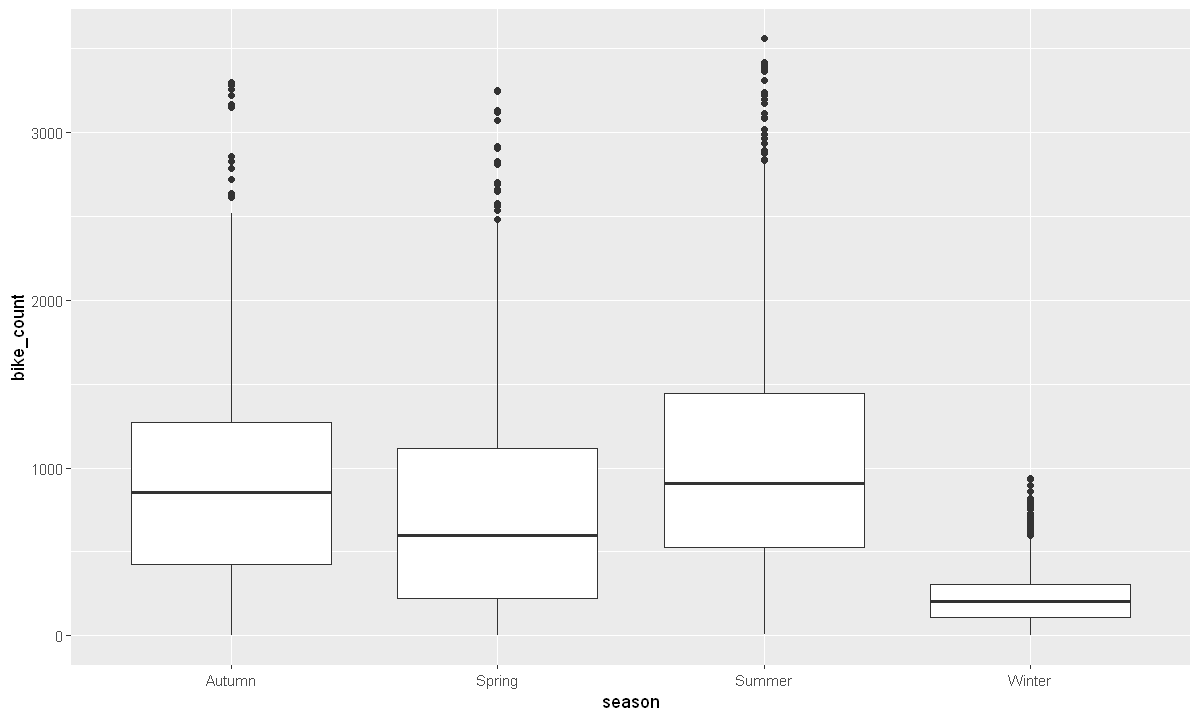

In [27]:
options(repr.plot.width = 10, repr.plot.height = 6)

bike_data |> 
select(bike_count, season, rain) |> 
ggplot(aes(x = season, y = bike_count)) + 
geom_boxplot()

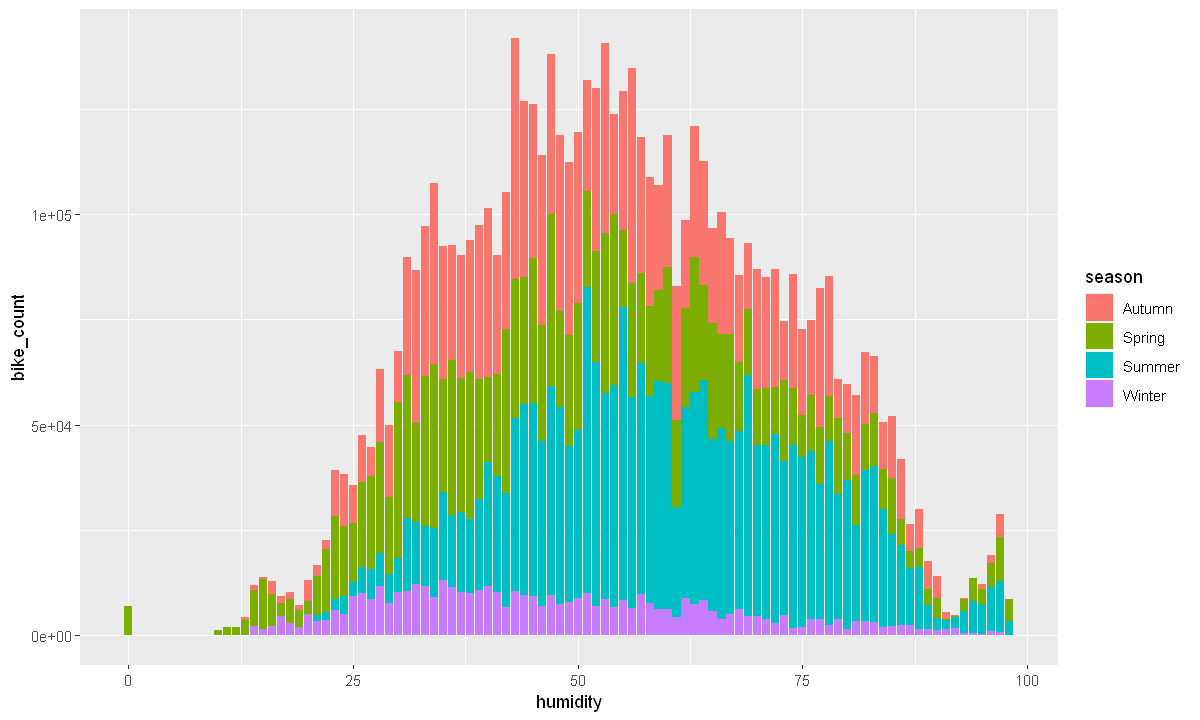

In [39]:
bike_data |> 
select(bike_count, season, humidity) |> 
ggplot(aes(x = humidity, y = bike_count)) + 
geom_bar(aes(fill = season), stat = "identity")

### building generative model

In [14]:
bike_data_4 <- bike_data %>%
         select(- c(date,dew_point_temp))

MLR_generative <- lm(bike_count~.,bike_data_4)

MLR_generative_result <- tidy(MLR_generative) %>% mutate_if(is.numeric, round, 2)
MLR_generative_result
nrow(MLR_generative_result)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),603.97,45.20,13.36,0
hour,28.69,0.75,38.23,0
temperature,27.18,0.88,30.77,0
⋮,⋮,⋮,⋮,⋮
seasonSummer,-160.46,17.38,-9.23,0
seasonWinter,-362.48,19.97,-18.15,0
holidayNo Holiday,120.36,22.35,5.39,0


[1] 13

In [63]:
bike_forward <- regsubsets(
  x=bike_count ~ ., 
  nvmax=12,
  data=bike_data_4,
  method="forward",
)
bike_forward

bike_forward_summary <- summary(bike_forward)

bike_forward_summary_df <- tibble(
   n_input_variables = 1:12,
   RSQ = bike_forward_summary$rsq,
   RSS = bike_forward_summary$rss,
   ADJ.R2 = bike_forward_summary$adjr2
)

Subset selection object
Call: regsubsets.formula(x = bike_count ~ ., nvmax = 12, data = bike_data_4, 
    method = "forward", )
12 Variables  (and intercept)
                  Forced in Forced out
hour                  FALSE      FALSE
temperature           FALSE      FALSE
humidity              FALSE      FALSE
wind_speed            FALSE      FALSE
visibility            FALSE      FALSE
radiation             FALSE      FALSE
rain                  FALSE      FALSE
snow                  FALSE      FALSE
seasonSpring          FALSE      FALSE
seasonSummer          FALSE      FALSE
seasonWinter          FALSE      FALSE
holidayNo Holiday     FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: forward

In [64]:
bike_forward_summary
bike_forward_summary_df


Subset selection object
Call: regsubsets.formula(x = bike_count ~ ., nvmax = 12, data = bike_data_4, 
    method = "forward", )
12 Variables  (and intercept)
                  Forced in Forced out
hour                  FALSE      FALSE
temperature           FALSE      FALSE
humidity              FALSE      FALSE
wind_speed            FALSE      FALSE
visibility            FALSE      FALSE
radiation             FALSE      FALSE
rain                  FALSE      FALSE
snow                  FALSE      FALSE
seasonSpring          FALSE      FALSE
seasonSummer          FALSE      FALSE
seasonWinter          FALSE      FALSE
holidayNo Holiday     FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: forward
          hour temperature humidity wind_speed visibility radiation rain snow
1  ( 1 )  " "  "*"         " "      " "        " "        " "       " "  " " 
2  ( 1 )  "*"  "*"         " "      " "        " "        " "       " "  " " 
3  ( 1 )  "*"  "*"         "*"      " " 

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.3166765,2386420903,0.3165958
2,0.4454842,1936576319,0.4453531
3,0.4909530,1777782394,0.4907725
⋮,⋮,⋮,⋮
10,0.5410271,1602904957,0.5404842
11,0.5414985,1601258438,0.5409019
12,0.5415509,1601075444,0.5409000
